<a href="https://colab.research.google.com/github/RobertoAlessandri/STSA/blob/main/STSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORTS

In [1]:
###----------Imports----------###

import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
import IPython.display as ipd
import scipy as sp
import pandas as pd
import soundfile as sf
from scipy.io import wavfile

##DEFINITIONS

In [2]:
###----------Defs----------###

def print_plot_play(x, Fs, text=''):
    print('%s Fs = %d, x.shape = %s, x.dtype = %s' % (text, Fs, x.shape, x.dtype))
    plt.figure(figsize=(10, 2)) # (6, 1.5)
    plt.plot(x, color='gray')
    plt.xlim([0, x.shape[0]])
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()
    ipd.display(ipd.Audio(data=x, rate=Fs))

LOADING FILES

WAV file:  Fs = 44100, x.shape = (486935,), x.dtype = float32


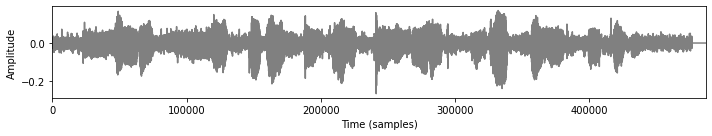

In [6]:
from IPython.core.pylabtools import select_figure_formats
###----------Reads----------###
Fs = 44100;

# Read/Load wav
fn_wav = os.path.join('source_SuzanneVega_vocal.wav')
sig_m, Fs = librosa.load(fn_wav, sr=Fs)
print_plot_play(x=sig_m, Fs=Fs, text='WAV file: ')
# Remove the mean to be sure to have a zero-mean signal
mean_sig = np.mean(sig_m)
sig = sig_m - mean_sig
L = len(sig) # Signal length
pow2 = np.floor(np.log2(L))
L_nfft = 2**pow2


## Short-Time Processing Params


In [75]:
## Short-time processing params
winlen = 2048 # Length of the analysis window # COMMENT ON WHAT IT CHANGES
win = np.hanning(winlen)
hopsize = int(winlen/4) # COMMENT ON WHAT IT CHANGES
numHopsPerFrame = winlen/hopsize
n_frames = int(np.floor((L-winlen)/hopsize) +1)
nfft = winlen # Number of FFT frequency bins# 

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


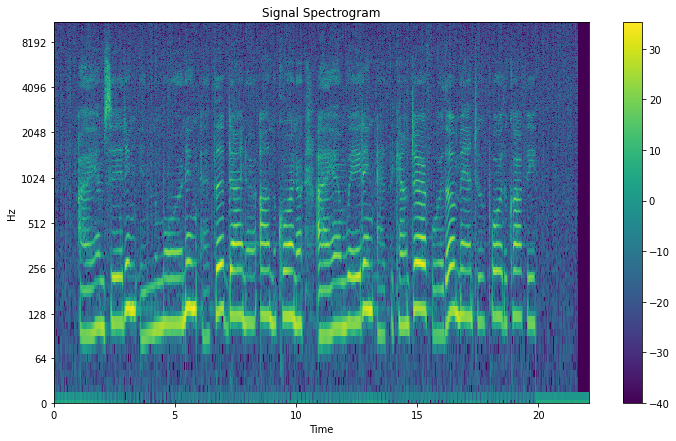

In [76]:
import librosa.display 
Sig = librosa.stft(sig, hop_length = hopsize)
plt.figure(figsize=(12, 7))
librosa.display.specshow(librosa.power_to_db(Sig**2), x_axis = 'time', y_axis='log', cmap='viridis');
plt.clim(-40, None);
plt.colorbar();
plt.title('Signal Spectrogram');

## Noise Estimation

We search for the more suited half-second frame to use for the noise
estimatation.
We search inside the audio signal for the frame with the best combination of zero-crossing rate (high) and short-time energy.

Noisiest frame is the number


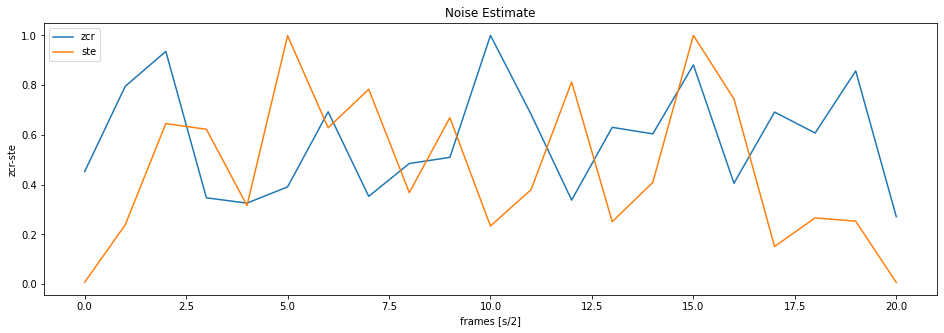

In [77]:
only_noise_samples = int(Fs/2)
hopsize_noise = int(only_noise_samples)
n_frames_noise = int(np.floor((L-only_noise_samples)/hopsize_noise) + 1) # number of
                                                                    # time 
                                                                    # frames

# These vectors are used for a later representation of the signal
#zcr_vector = np.zeros([n_frames_noise])
#ste_vector = np.zeros([n_frames_noise])
zcr_vector = []
ste_vector = []

# We use as starting values for the later searche of the optimimum ones, the 
# average zcr (Zero-Crossing Rate)  and ste (Short-Time Energy) of the whole 
# audio signal
#zcr_whole = (1/(L-1))*np.sum(np.abs(np.diff(np.sign(sig))));
zcr_whole = np.mean(librosa.feature.zero_crossing_rate(sig, frame_length = winlen, hop_length = hopsize))
ste_whole = np.sum(sig**2) / L
zcr = zcr_whole
#print('zcr_whole = ', zcr_whole)
ste = ste_whole
#print('ste_whole = ', ste_whole)
noise_frame = 0 # we are going to save the frame in order better understand
                # if the algorithm pointed out a reasonable frame

for nn in range (0, n_frames_noise-1):
  # Segment the corrupted signal
  x_n = np.asarray(sig[nn*hopsize_noise+1 : nn*hopsize_noise + only_noise_samples])

  #zcr_frame = (1/(only_noise_samples-1))*np.sum(np.abs(np.diff(np.sign(x_n))))
  zcr_frame = np.mean(librosa.feature.zero_crossing_rate(x_n))
  #print('zcr frame = ', zcr_frame)
  ste_frame = sum(x_n**2)/only_noise_samples
  #print('ste frame = ', ste_frame)
  zcr_vector.append(zcr_frame)
  ste_vector.append(ste_frame)
  # We assume that the noisiest part of an audio signal is the one with the 
  # lowest ste and highest zcr
  if (zcr_frame > zcr and ste_frame < ste):
    noise_frame = nn
    zcr = zcr_frame
    ste = ste_frame
    #print('x noise = ', x_noise)
    x_noise = x_n

# Vector normalization just for visualization
zcr_vector_n = zcr_vector / np.max(zcr_vector);
ste_vector_n = ste_vector / np.max(ste_vector);
t_nn = np.arange(0, n_frames_noise - 1)

plt.figure(figsize=(16,5))
# summarize history for accuracy
plt.plot(zcr_vector_n)
plt.plot(ste_vector_n)
plt.title('Noise Estimate')
plt.ylabel('zcr-ste')
plt.xlabel('frames [s/2]')
plt.legend(['zcr', 'ste'], loc='upper left')

print('Noisiest frame is the number'.format(noise_frame))

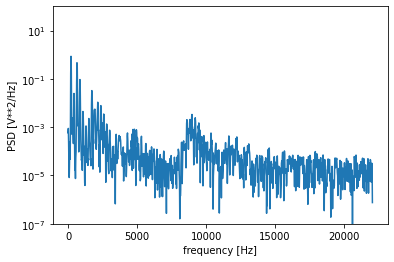

In [78]:
# Noise Power Spectrum Estimate
r_v = np.correlate(x_noise, x_noise)
P_v = np.abs(np.fft.fft(r_v, nfft))
mean_noise = np.mean(sig_m[noise_frame*hopsize_noise + 1 : noise_frame*hopsize_noise + only_noise_samples]);

f, Pxx_den = sp.signal.periodogram(x_noise, fs=1.0, window=win, nfft=nfft, detrend='constant', return_onesided=True, scaling='density', axis=- 1)
PSD_Noise_Estimate = Pxx_den



plt.semilogy(f * Fs, PSD_Noise_Estimate)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

## Suppression Rule

In [82]:
frames_ratio = n_frames / n_frames_noise # will be explained later
precision = np.finfo(np.float32).eps

## Parameters
# These are the parameters to tune in order to have a desired type of suppresion
a = 1
b = 1
c = 1

## Rule

out = []
out = np.zeros(L)

for n in range (0, n_frames-1):
  # Segment the corrupted signal
  x_n = sig[n*hopsize: n*hopsize + winlen]
  x_n_w = win * x_n # Windowing
  X_n = np.fft.fft(x_n_w, nfft) # FFT
  P_X = np.abs(X_n)**2
  #P_X_min = np.min(P_X(P_X>0)) / 10
  for i in range(0, len(P_X)):
    if P_X[i] == 0:
      P_X[i] = precision # avoids numerical issues when P_X == 0
  N = len(X_n)

  # Gain Estimation
  Z_B = P_X - a * (P_v**c)
  for i in range(0, len(Z_B)):
    if Z_B[i] < 0:
      Z_B[i] = 0 # This should be considered as the Power Spectrum of the 
                 # "clean" signal. So as Power Spectrum, it can't have negative
                 # values (which may appear due to random fluctuations)
  Z = Z_B/P_X
  G = Z**b

  # Apply the attenuation to the frame spectrum
  S = X_n * G

  # Compute the inverse FFT of the filtered frame. This corresponds to an 
  # estimate of the clean speech
  s_n = np.fft.ifft(S, nfft)

  # Window the filtered time-domain frame
  s_n_w = win*s_n

  # OverLap-and-Add (OLA)
  out[n*hopsize  : n*hopsize + winlen] = out[n*hopsize  : n*hopsize + winlen] + s_n_w;

  # Save the filter to visualize how it attenuates what should be the noisiest 
  # frame
  if (n == np.floor(noise_frame*frames_ratio)):
    clean_frame = n
    G_n = G
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: ComplexWarning: Casting complex values to real discards the imaginary part


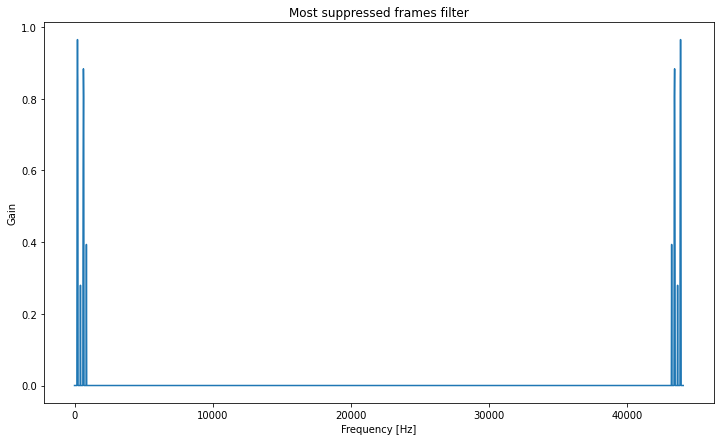

In [92]:
f_G = Fs*np.arange(len(G_n))/nfft
plt.figure(figsize=(12, 7))
plt.plot(f_G, G_n)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.title('Most suppressed frames filter');

## Final Results

SNR in = 
SNR out = 
WAV file:  Fs = 44100, x.shape = (486935,), x.dtype = float64


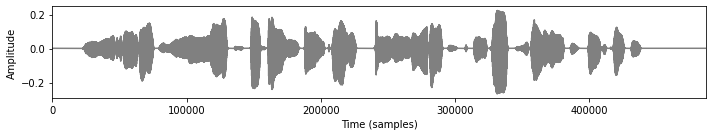

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


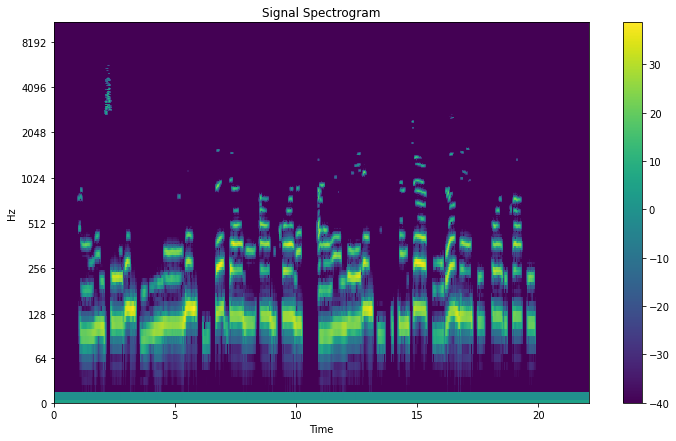

In [96]:
MSE = np.sum((out - sig )**2)/len((out-sig)**2)
var_out = np.var(out)
var_in = np.var(sig)

# Power Spectrum of original and cleaned audio signal
P_S_total = np.abs(np.fft.fft(out, nfft))**2
P_X_total = np.abs(np.fft.fft(sig, nfft))**2

# Power Spectrum Noise Estimate for clean signal
v_clean = out[noise_frame*hopsize_noise + 1 : noise_frame*hopsize_noise + only_noise_samples];
r_v_clean = np.correlate(v_clean, v_clean);
P_v_new = np.abs(np.fft.fft(r_v, nfft))**2 + precision;
P_v_clean_new = np.abs(np.fft.fft(r_v_clean, nfft))**2 + precision;

# Singal-to-Noise Ratio (SNR) before and after attenuation
SNR_in = np.mean(librosa.power_to_db(np.mean((P_X_total/P_v_new))))
SNR_out = np.mean(librosa.power_to_db(np.mean((P_S_total/P_v_clean_new))))
print('SNR in = '.format(SNR_in))
print('SNR out = '.format(SNR_out))

out = out + mean_sig - mean_noise

print_plot_play(x=out, Fs=Fs, text='WAV file: ')
Out = librosa.stft(out, hop_length = hopsize)
plt.figure(figsize=(12, 7))
librosa.display.specshow(librosa.power_to_db(Out**2), x_axis = 'time', y_axis='log', cmap='viridis');
plt.clim(-40, None);
plt.colorbar();
plt.title('Signal Spectrogram');
